In [148]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sys
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import plotly.graph_objs as go
#import plotly.plotly as py
import datetime as dt
import matplotlib.dates as mdates

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

In [4]:
from google.colab import files
uploaded = files.upload()

Saving crypto-markets.csv to crypto-markets.csv


In [5]:
import io
df = pd.read_csv(io.StringIO(uploaded['crypto-markets.csv'].decode('utf-8')))

In [6]:
df.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32


In [7]:
df.shape #total number of rows and columns

(942297, 13)

In [8]:
df.isnull().sum() #total of null values column wise

,0
slug,0
symbol,0
name,0
date,0
ranknow,0
open,0
high,0
low,0
close,0
volume,0


In [9]:
df.describe() #statistical readings of all the columns

,ranknow,open,high,low,close,volume,market,close_ratio,spread
count,942297.000000,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,942297.000000,9.422970e+05
mean,1000.170608,3.483522e+02,4.085930e+02,2.962526e+02,3.461018e+02,8.720383e+06,1.725060e+08,0.459499,1.123400e+02
std,587.575283,1.318436e+04,1.616386e+04,1.092931e+04,1.309822e+04,1.839802e+08,3.575590e+09,0.326160,6.783713e+03
min,1.000000,2.500000e-09,3.200000e-09,2.500000e-10,2.000000e-10,0.000000e+00,0.000000e+00,-1.000000,0.000000e+00
25%,465.000000,2.321000e-03,2.628000e-03,2.044000e-03,2.314000e-03,1.750000e+02,2.958100e+04,0.162900,0.000000e+00
50%,1072.000000,2.398300e-02,2.680200e-02,2.143700e-02,2.389200e-02,4.278000e+03,5.227960e+05,0.432400,0.000000e+00
75%,1484.000000,2.268600e-01,2.508940e-01,2.043910e-01,2.259340e-01,1.190900e+05,6.874647e+06,0.745800,3.000000e-02
max,2072.000000,2.298390e+06,2.926100e+06,2.030590e+06,2.300740e+06,2.384090e+10,3.265025e+11,1.000000,1.770563e+06


In [10]:
df.info() #info on all the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942297 entries, 0 to 942296
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   slug         942297 non-null  object 
 1   symbol       942297 non-null  object 
 2   name         942297 non-null  object 
 3   date         942297 non-null  object 
 4   ranknow      942297 non-null  int64  
 5   open         942297 non-null  float64
 6   high         942297 non-null  float64
 7   low          942297 non-null  float64
 8   close        942297 non-null  float64
 9   volume       942297 non-null  float64
 10  market       942297 non-null  float64
 11  close_ratio  942297 non-null  float64
 12  spread       942297 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 93.5+ MB


In [11]:
data = df #copy of dataframe

#set up a column with an index so I can only sample 1/10th of the dataset
data["row_id"]= range(1, len(data) + 1)

In [12]:
#drop columns I'm not using
data_=data.drop(['slug','ranknow','volume','market'], axis=1)
data_.head()

,symbol,name,date,open,high,low,close,close_ratio,spread,row_id
0,BTC,Bitcoin,2013-04-28,135.30,135.98,132.10,134.21,0.5438,3.88,1
1,BTC,Bitcoin,2013-04-29,134.44,147.49,134.00,144.54,0.7813,13.49,2
2,BTC,Bitcoin,2013-04-30,144.00,146.93,134.05,139.00,0.3843,12.88,3
3,BTC,Bitcoin,2013-05-01,139.00,139.89,107.72,116.99,0.2882,32.17,4
4,BTC,Bitcoin,2013-05-02,116.38,125.60,92.28,105.21,0.3881,33.32,5


In [13]:
data_.set_index('row_id', inplace=True)
data_.head()

,symbol,name,date,open,high,low,close,close_ratio,spread
row_id,,,,,,,,,
1,BTC,Bitcoin,2013-04-28,135.30,135.98,132.10,134.21,0.5438,3.88
2,BTC,Bitcoin,2013-04-29,134.44,147.49,134.00,144.54,0.7813,13.49
3,BTC,Bitcoin,2013-04-30,144.00,146.93,134.05,139.00,0.3843,12.88
4,BTC,Bitcoin,2013-05-01,139.00,139.89,107.72,116.99,0.2882,32.17
5,BTC,Bitcoin,2013-05-02,116.38,125.60,92.28,105.21,0.3881,33.32


In [14]:
#counitng unique symbols
data["name"].unique() #total number of unique cryptos

array(['Bitcoin', 'XRP', 'Ethereum', ..., '42-coin', 'Bit20', 'Project-X'],
      dtype=object)

In [15]:
#set date to timestamp format
data_['date'] = pd.to_datetime(data_['date']).dt.date

In [16]:
#pick out the currency for two years span (2016>)

date = data_[data_['date'] >= dt.date(2016, 1, 1)]

In [17]:
#show if each one closed up or down each day
date['pos_neg']= date['open']-date['close']
date.head()
#create a binary column - 0 = gain, 1 = loss to have something to predict
date['Up/Down'] = np.where(date['pos_neg']>0, '0', '1')

In [18]:
#create data sets for different crypto currencies
etherdate = date[date['symbol']=='ETH']
ltcdate = date[date['symbol']=='LTC']
tetherdate = date[date['symbol']=='USDT']
cardanodate = date[date['symbol']=='ADA']
rippledate = date[date['symbol']=='XRP']

In [19]:
#concat the different frames into one
frames=[etherdate,ltcdate,tetherdate,cardanodate,rippledate]
five_crypto = pd.concat(frames)

In [20]:
five_crypto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4681 entries, 4134 to 3986
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       4681 non-null   object 
 1   name         4681 non-null   object 
 2   date         4681 non-null   object 
 3   open         4681 non-null   float64
 4   high         4681 non-null   float64
 5   low          4681 non-null   float64
 6   close        4681 non-null   float64
 7   close_ratio  4681 non-null   float64
 8   spread       4681 non-null   float64
 9   pos_neg      4681 non-null   float64
 10  Up/Down      4681 non-null   object 
dtypes: float64(7), object(4)
memory usage: 438.8+ KB


<Axes: xlabel='symbol', ylabel='count'>

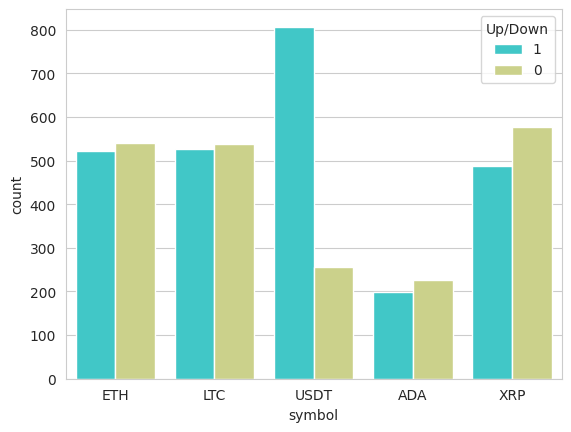

In [21]:
#this chart shows each of the six and the number of times they closed up for the day.
sns.set_style('whitegrid')
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Use catplot instead of factorplot
g = sns.catplot(
    x="symbol",
    y="close_ratio",
    hue="Up/Down",
    data=five_crypto,
    kind="bar",
    height=6,
    palette="muted",
    legend_out=True
)

# Customize the plot
g.despine(left=True)
g.set_ylabels("Ratio Count")
sns.countplot(x='symbol',hue='Up/Down',data=five_crypto,palette='rainbow')

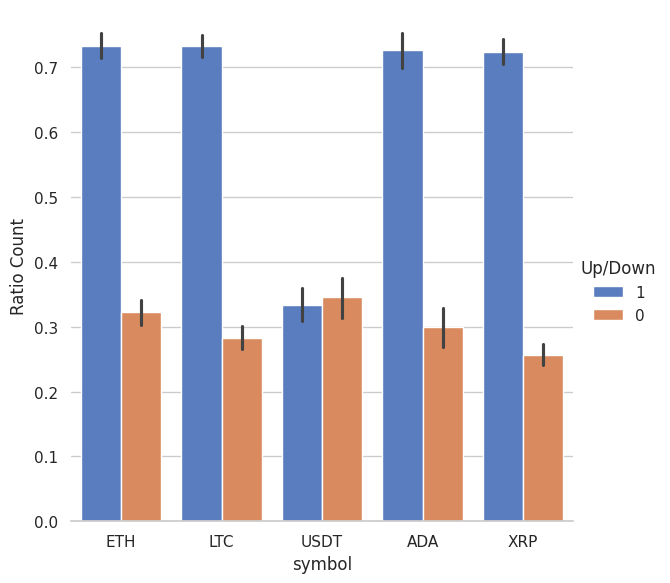

In [63]:
# Set the style
sns.set(style="whitegrid")

# Use catplot to create a single plot
g = sns.catplot(
    x="symbol",
    y="close_ratio",
    hue="Up/Down",
    data=five_crypto,
    kind="bar",
    height=6,
    palette="muted",
    legend_out=True
)

# Customize the plot
g.despine(left=True)
g.set_ylabels("Ratio Count")


In [24]:
data['market_billion'] = data['market'] / 1000000000
data['volume_million'] = data['volume'] / 1000000000
data['volume_billion'] = data['volume']

In [28]:
# Let's prepare one dataframe where we will observe closing prices for each currency
wide_format = data.groupby(['date', 'name'])['close'].last().unstack()
wide_format.head(3)

name,0chain,0x,0xBitcoin,0xcert,1World,2GIVE,300 Token,42-coin,4NEW,808Coin,...,imbrex,indaHash,nDEX,nUSD,savedroid,smARTOFGIVING,ugChain,vSlice,vSportCoin,wys Token
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


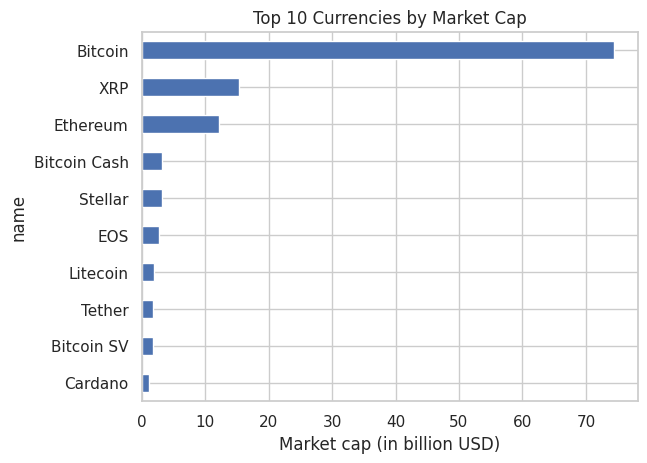

In [29]:
ax = data.groupby(['name'])['market_billion'].last().sort_values(ascending=False).head(10).sort_values().plot(kind='barh');
ax.set_xlabel("Market cap (in billion USD)");
plt.title("Top 10 Currencies by Market Cap");

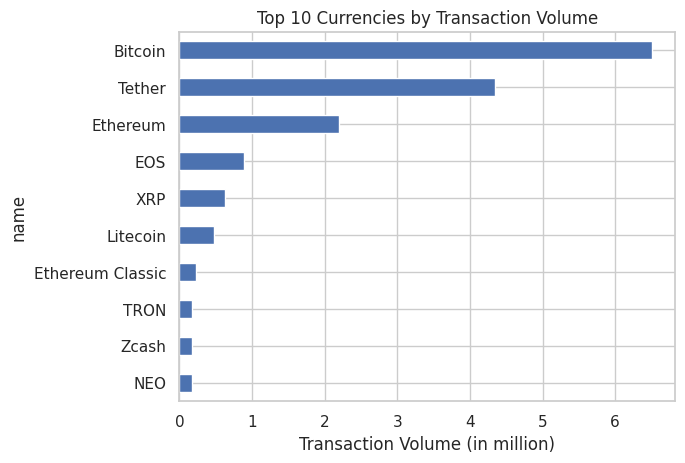

In [30]:
ax = data.groupby(['name'])['volume_million'].last().sort_values(ascending=False).head(10).sort_values().plot(kind='barh');
ax.set_xlabel("Transaction Volume (in million)");
plt.title("Top 10 Currencies by Transaction Volume");

In [31]:
# For sake of convenience, let's define the top 6 currencies

top_6_currency_names = data.groupby(['name'])['market'].last().sort_values(ascending=False).head(6).index
data_top_6_currencies = data[data['name'].isin(top_6_currency_names)]
data_top_6_currencies.head(5)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,row_id,market_billion,volume_million,volume_billion
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88,1,1.488567,0.0,0.0
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49,2,1.603769,0.0,0.0
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88,3,1.542813,0.0,0.0
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17,4,1.298955,0.0,0.0
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32,5,1.168517,0.0,0.0


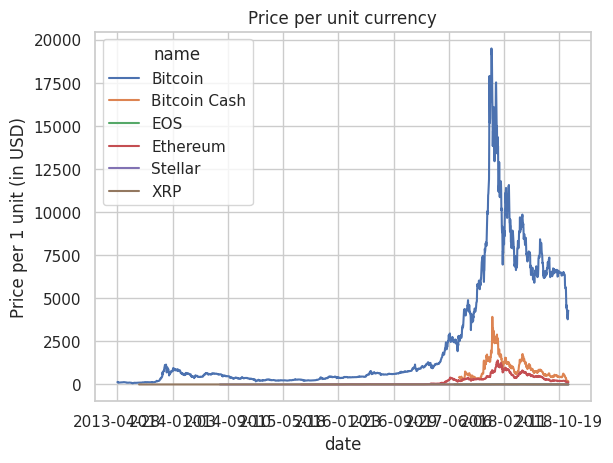

In [32]:
ax = data_top_6_currencies.groupby(['date', 'name'])['close'].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)");
plt.title("Price per unit currency");

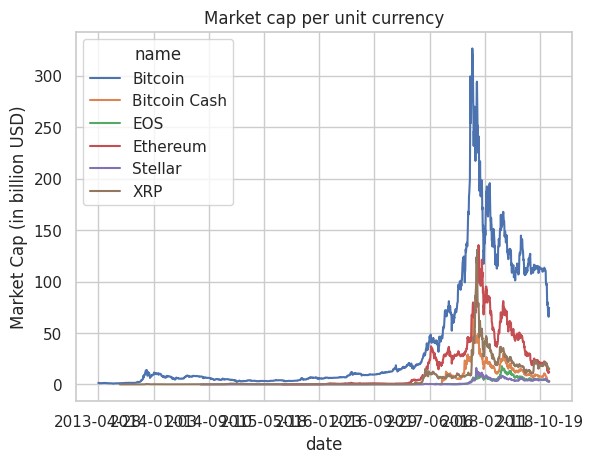

In [33]:
ax = data_top_6_currencies.groupby(['date', 'name'])['market_billion'].mean().unstack().plot();
ax.set_ylabel("Market Cap (in billion USD)");
plt.title("Market cap per unit currency");

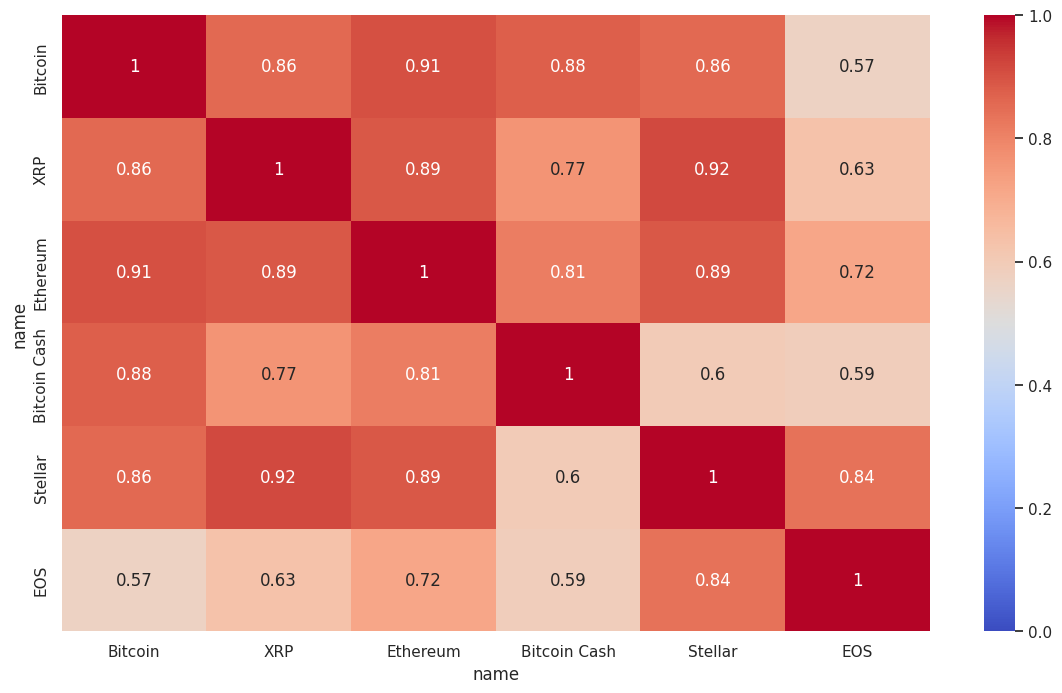

In [34]:
#co-relation between different cryptos
plt.figure(figsize=(14,8))
sns.heatmap(wide_format[top_6_currency_names].corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True);

In [35]:
data_top_6_currencies.head(5)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,row_id,market_billion,volume_million,volume_billion
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88,1,1.488567,0.0,0.0
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49,2,1.603769,0.0,0.0
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88,3,1.542813,0.0,0.0
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17,4,1.298955,0.0,0.0
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32,5,1.168517,0.0,0.0


In [36]:
data_top_6_currencies.drop(['ranknow'],axis=1)

,slug,symbol,name,date,open,high,low,close,volume,market,close_ratio,spread,row_id,market_billion,volume_million,volume_billion
0,bitcoin,BTC,Bitcoin,2013-04-28,135.30,135.98,132.10,134.21,0.000000e+00,1.488567e+09,0.5438,3.88,1,1.488567,0.000000,0.000000e+00
1,bitcoin,BTC,Bitcoin,2013-04-29,134.44,147.49,134.00,144.54,0.000000e+00,1.603769e+09,0.7813,13.49,2,1.603769,0.000000,0.000000e+00
2,bitcoin,BTC,Bitcoin,2013-04-30,144.00,146.93,134.05,139.00,0.000000e+00,1.542813e+09,0.3843,12.88,3,1.542813,0.000000,0.000000e+00
3,bitcoin,BTC,Bitcoin,2013-05-01,139.00,139.89,107.72,116.99,0.000000e+00,1.298955e+09,0.2882,32.17,4,1.298955,0.000000,0.000000e+00
4,bitcoin,BTC,Bitcoin,2013-05-02,116.38,125.60,92.28,105.21,0.000000e+00,1.168517e+09,0.3881,33.32,5,1.168517,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,eos,EOS,EOS,2018-11-25,3.27,3.43,3.03,3.35,1.057330e+09,3.035994e+09,0.8000,0.40,7783,3.035994,1.057330,1.057330e+09
7783,eos,EOS,EOS,2018-11-26,3.35,3.41,3.08,3.18,9.845280e+08,2.885294e+09,0.3030,0.33,7784,2.885294,0.984528,9.845280e+08
7784,eos,EOS,EOS,2018-11-27,3.18,3.18,2.90,3.03,9.577230e+08,2.746077e+09,0.4643,0.28,7785,2.746077,0.957723,9.577230e+08
7785,eos,EOS,EOS,2018-11-28,3.03,3.37,3.03,3.28,8.601480e+08,2.971913e+09,0.7353,0.34,7786,2.971913,0.860148,8.601480e+08


In [37]:
data_top_6_currencies.shape

(7787, 17)

#Bitcoin

In [38]:
#bitcoin
df1 = data_top_6_currencies[data_top_6_currencies['name']=='Bitcoin']

df1.shape

(2042, 17)

In [39]:
print(df1)

         slug symbol     name        date  ranknow     open     high      low  \
0     bitcoin    BTC  Bitcoin  2013-04-28        1   135.30   135.98   132.10   
1     bitcoin    BTC  Bitcoin  2013-04-29        1   134.44   147.49   134.00   
2     bitcoin    BTC  Bitcoin  2013-04-30        1   144.00   146.93   134.05   
3     bitcoin    BTC  Bitcoin  2013-05-01        1   139.00   139.89   107.72   
4     bitcoin    BTC  Bitcoin  2013-05-02        1   116.38   125.60    92.28   
...       ...    ...      ...         ...      ...      ...      ...      ...   
2037  bitcoin    BTC  Bitcoin  2018-11-25        1  3880.78  4120.87  3585.06   
2038  bitcoin    BTC  Bitcoin  2018-11-26        1  4015.07  4107.14  3643.92   
2039  bitcoin    BTC  Bitcoin  2018-11-27        1  3765.95  3862.96  3661.01   
2040  bitcoin    BTC  Bitcoin  2018-11-28        1  3822.47  4385.90  3822.47   
2041  bitcoin    BTC  Bitcoin  2018-11-29        1  4269.00  4413.02  4145.77   

        close        volume

In [40]:
df1.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,row_id,market_billion,volume_million,volume_billion
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88,1,1.488567,0.0,0.0
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49,2,1.603769,0.0,0.0
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88,3,1.542813,0.0,0.0
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17,4,1.298955,0.0,0.0
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32,5,1.168517,0.0,0.0


In [41]:
d = df1.iloc[:, 5:10]
print(d.head())
print(d.shape)

     open    high     low   close  volume
0  135.30  135.98  132.10  134.21     0.0
1  134.44  147.49  134.00  144.54     0.0
2  144.00  146.93  134.05  139.00     0.0
3  139.00  139.89  107.72  116.99     0.0
4  116.38  125.60   92.28  105.21     0.0
(2042, 5)


Text(0.5, 1.0, 'Price of Bitcoin')

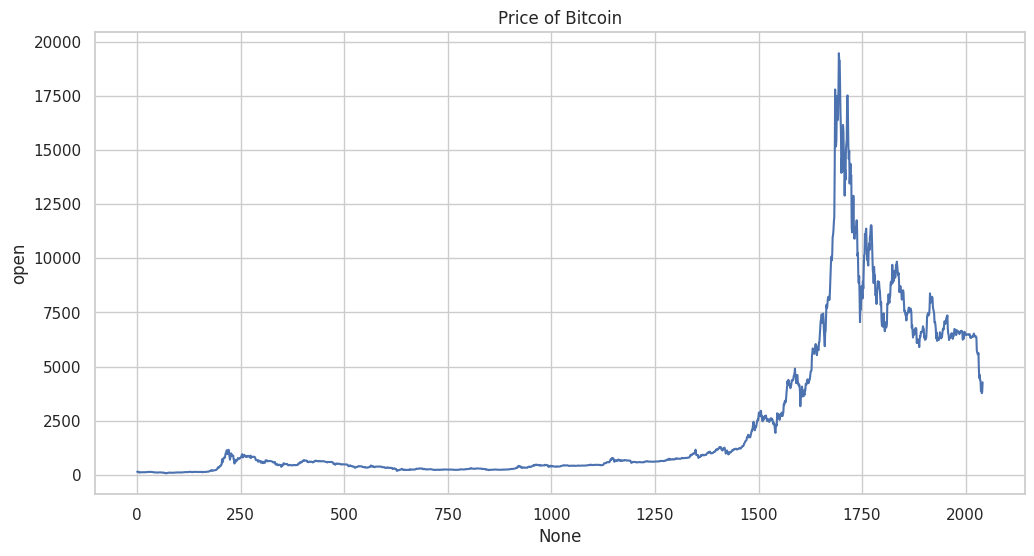

In [42]:
plt.figure(figsize=(12,6))
sns.lineplot(x=d.index, y="open", data=d).set_title("Price of Bitcoin")

In [43]:
data = d.iloc[:, 0]
print(len(data))
print(data)
hist = []
target = []
length = 90
for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

2042
0        135.30
1        134.44
2        144.00
3        139.00
4        116.38
         ...   
2037    3880.78
2038    4015.07
2039    3765.95
2040    3822.47
2041    4269.00
Name: open, Length: 2042, dtype: float64


In [44]:
print(hist[1][89])
print(data[90])
print(target[0])

96.95
96.02
96.02


In [45]:
hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1,1)

In [46]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
hist_scaled = sc.fit_transform(hist)
target_scaled = sc.fit_transform(target)

In [47]:
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(1952, 90, 1)


In [48]:
X_train = hist_scaled[:1900,:,:]
X_test = hist_scaled[1900:,:,:]
y_train = target_scaled[:1900,:]
y_test = target_scaled[1900:,:]

In [49]:
import tensorflow as tf
from tensorflow.keras import layers

In [50]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(90,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 90, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,025 (82.13 KB)

 Trainable params: 21,025 (82.13 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [52]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.0166
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0111
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0092
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 0.0095
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - loss: 0.0091
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0160
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 0.0091
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0095
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.0102
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0100
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - loss: 0.0084
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.0074
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.0096
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - loss: 0.0093
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/ste

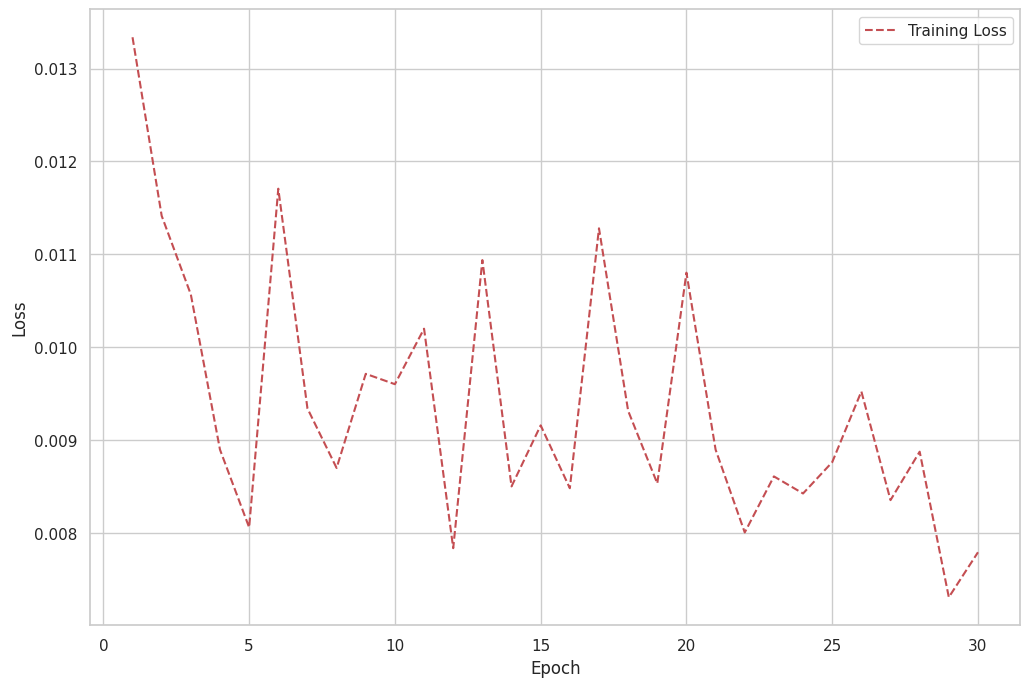

In [53]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 728ms/step


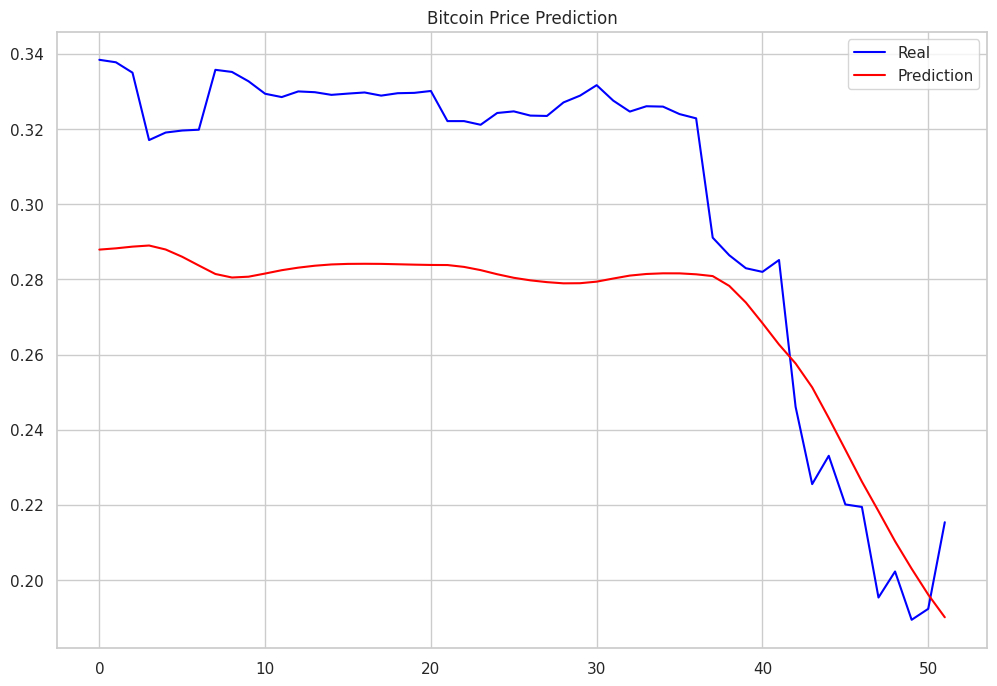

In [54]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

#XRP (Ripple)

In [55]:
#bitcoin
df2 = data_top_6_currencies[data_top_6_currencies['name']=='XRP']

df2.shape

(1944, 17)

In [56]:
print(df2)

        slug symbol name        date  ranknow      open      high       low  \
2042  ripple    XRP  XRP  2013-08-04        2  0.005874  0.005927  0.005874   
2043  ripple    XRP  XRP  2013-08-05        2  0.005875  0.005980  0.005613   
2044  ripple    XRP  XRP  2013-08-06        2  0.005637  0.005661  0.004629   
2045  ripple    XRP  XRP  2013-08-07        2  0.004669  0.004682  0.004333   
2046  ripple    XRP  XRP  2013-08-08        2  0.004397  0.004424  0.004175   
...      ...    ...  ...         ...      ...       ...       ...       ...   
3981  ripple    XRP  XRP  2018-11-25        2  0.374511  0.386333  0.324953   
3982  ripple    XRP  XRP  2018-11-26        2  0.375553  0.388696  0.342019   
3983  ripple    XRP  XRP  2018-11-27        2  0.353977  0.367645  0.342991   
3984  ripple    XRP  XRP  2018-11-28        2  0.360313  0.401583  0.360313   
3985  ripple    XRP  XRP  2018-11-29        2  0.391862  0.392465  0.373789   

         close        volume        market  close_r

In [57]:
df2.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,row_id,market_billion,volume_million,volume_billion
2042,ripple,XRP,XRP,2013-08-04,2,0.005874,0.005927,0.005874,0.005882,0.0,45983577.0,0.1509,0.0,2043,0.045984,0.0,0.0
2043,ripple,XRP,XRP,2013-08-05,2,0.005875,0.005980,0.005613,0.005613,0.0,43879157.0,0.0000,0.0,2044,0.043879,0.0,0.0
2044,ripple,XRP,XRP,2013-08-06,2,0.005637,0.005661,0.004629,0.004680,0.0,36591008.0,0.0494,0.0,2045,0.036591,0.0,0.0
2045,ripple,XRP,XRP,2013-08-07,2,0.004669,0.004682,0.004333,0.004417,0.0,34534121.0,0.2407,0.0,2046,0.034534,0.0,0.0
2046,ripple,XRP,XRP,2013-08-08,2,0.004397,0.004424,0.004175,0.004254,0.0,33258632.0,0.3173,0.0,2047,0.033259,0.0,0.0


In [58]:
d2 = df2.iloc[:, 5:10]
print(d2.head())
print(d2.shape)

          open      high       low     close  volume
2042  0.005874  0.005927  0.005874  0.005882     0.0
2043  0.005875  0.005980  0.005613  0.005613     0.0
2044  0.005637  0.005661  0.004629  0.004680     0.0
2045  0.004669  0.004682  0.004333  0.004417     0.0
2046  0.004397  0.004424  0.004175  0.004254     0.0
(1944, 5)


Text(0.5, 1.0, 'Price of Ripple')

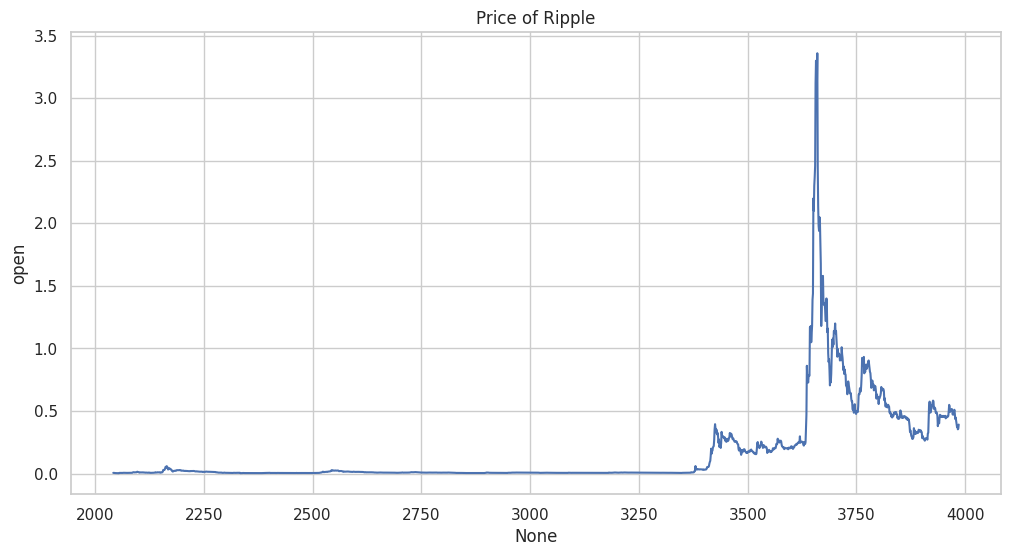

In [64]:
plt.figure(figsize=(12,6))
sns.lineplot(x=d2.index, y="open", data=d2).set_title("Price of Ripple")

In [65]:
data = d2.iloc[:, 0]

print(data)

2042    0.005874
2043    0.005875
2044    0.005637
2045    0.004669
2046    0.004397
          ...   
3981    0.374511
3982    0.375553
3983    0.353977
3984    0.360313
3985    0.391862
Name: open, Length: 1944, dtype: float64


In [66]:
hist = []
target = []
length = 90
for i in range(2042,len(data)-length):
    x = data[2042:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [67]:
hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1,1)

In [68]:
hist = hist.reshape(-1,1)

In [72]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

hist = []
target = []
length = 90

# Get the starting index of the data
start_index = data.index.min()

# Iterate through the data, ensuring you stay within the valid index range
for i in range(len(data) - length):
    # Use iloc to access by position, as the index may not be consecutive integers
    x = data.iloc[i : i + length]
    y = data.iloc[i + length]
    hist.append(x.values) # Store values as numpy array
    target.append(y)

hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1, 1)

# Reshape hist
hist = hist.reshape(hist.shape[0], -1)

sc = MinMaxScaler

In [73]:
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(1952, 90, 1)


In [75]:
X_train = hist_scaled[:1900,:,:]
X_test = hist_scaled[1900:,:,:]
y_train = target_scaled[:1900,:]
y_test = target_scaled[1900:,:]

In [74]:
import tensorflow as tf
from tensorflow.keras import layers

In [76]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(90,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 90, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 90, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,025 (82.13 KB)

 Trainable params: 21,025 (82.13 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [78]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 0.0197
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0088
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.0098
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - loss: 0.0103
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.0096
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0083
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 0.0078
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 0.0084
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0100
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0080
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 0.0078
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0110
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0081
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.0096
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 495ms/step


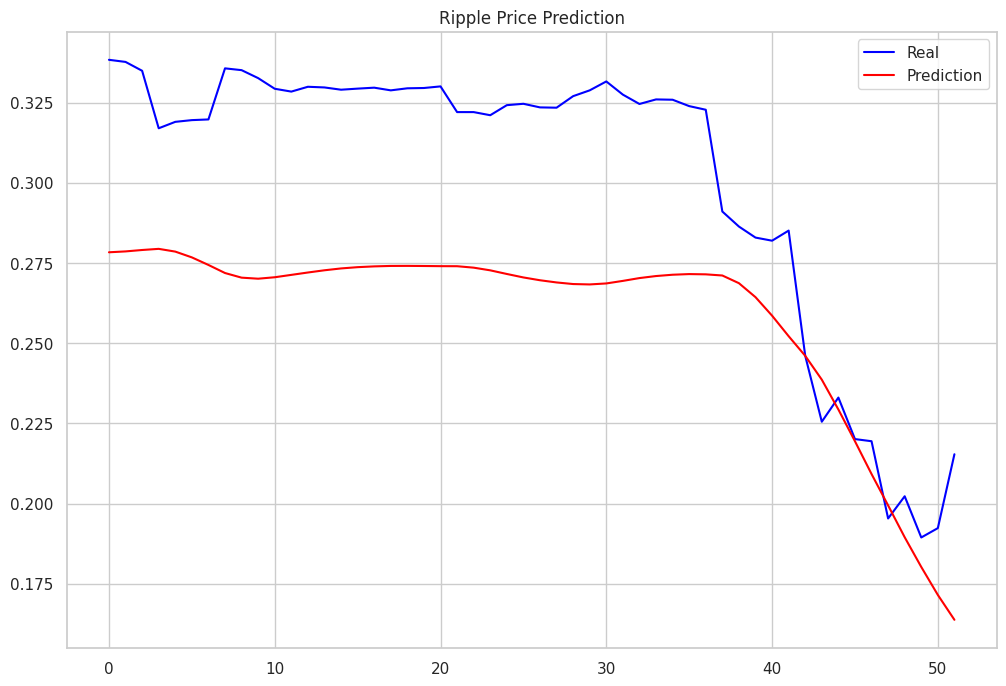

In [79]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Ripple Price Prediction')
plt.legend()
plt.show()

#Ethereum

In [80]:
#bitcoin
df3 = data_top_6_currencies[data_top_6_currencies['slug']=='ethereum']

df3.shape

(1211, 17)

In [81]:
print(df3)

          slug symbol      name        date  ranknow        open        high  \
3986  ethereum    ETH  Ethereum  2015-08-07        3    2.830000    3.540000   
3987  ethereum    ETH  Ethereum  2015-08-08        3    2.790000    2.800000   
3988  ethereum    ETH  Ethereum  2015-08-09        3    0.706136    0.879810   
3989  ethereum    ETH  Ethereum  2015-08-10        3    0.713989    0.729854   
3990  ethereum    ETH  Ethereum  2015-08-11        3    0.708087    1.130000   
...        ...    ...       ...         ...      ...         ...         ...   
5192  ethereum    ETH  Ethereum  2018-11-25        3  113.130000  118.880000   
5193  ethereum    ETH  Ethereum  2018-11-26        3  116.340000  118.200000   
5194  ethereum    ETH  Ethereum  2018-11-27        3  107.910000  111.840000   
5195  ethereum    ETH  Ethereum  2018-11-28        3  110.200000  126.050000   
5196  ethereum    ETH  Ethereum  2018-11-29        3  122.720000  123.230000   

             low       close        vol

In [82]:
df3.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,row_id,market_billion,volume_million,volume_billion
3986,ethereum,ETH,Ethereum,2015-08-07,3,2.830000,3.540000,2.520000,2.770000,164329.0,166610555.0,0.2451,1.02,3987,0.166611,0.000164,164329.0
3987,ethereum,ETH,Ethereum,2015-08-08,3,2.790000,2.800000,0.714725,0.753325,674188.0,45486894.0,0.0185,2.09,3988,0.045487,0.000674,674188.0
3988,ethereum,ETH,Ethereum,2015-08-09,3,0.706136,0.879810,0.629191,0.701897,532170.0,42399573.0,0.2901,0.25,3989,0.042400,0.000532,532170.0
3989,ethereum,ETH,Ethereum,2015-08-10,3,0.713989,0.729854,0.636546,0.708448,405283.0,42818364.0,0.7706,0.09,3990,0.042818,0.000405,405283.0
3990,ethereum,ETH,Ethereum,2015-08-11,3,0.708087,1.130000,0.663235,1.070000,1463100.0,64569288.0,0.8715,0.47,3991,0.064569,0.001463,1463100.0


In [83]:
d3 = df3.iloc[:, 5:10]
print(d3.head())
print(d3.shape)

          open      high       low     close     volume
3986  2.830000  3.540000  2.520000  2.770000   164329.0
3987  2.790000  2.800000  0.714725  0.753325   674188.0
3988  0.706136  0.879810  0.629191  0.701897   532170.0
3989  0.713989  0.729854  0.636546  0.708448   405283.0
3990  0.708087  1.130000  0.663235  1.070000  1463100.0
(1211, 5)


Text(0.5, 1.0, 'Price of Ethereum')

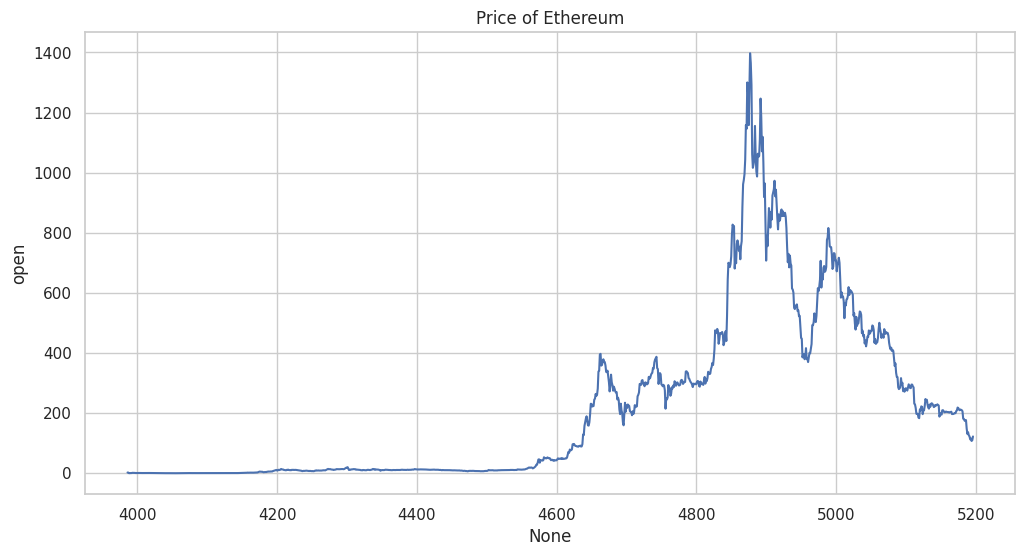

In [84]:
plt.figure(figsize=(12,6))
sns.lineplot(x=d3.index, y="open", data=d3).set_title("Price of Ethereum")

In [85]:
data = d3.iloc[:, 0]

print(data)

3986      2.830000
3987      2.790000
3988      0.706136
3989      0.713989
3990      0.708087
           ...    
5192    113.130000
5193    116.340000
5194    107.910000
5195    110.200000
5196    122.720000
Name: open, Length: 1211, dtype: float64


In [86]:
hist = []
target = []
length = 90
for i in range(3986,len(data)-length):
    x = data[3986:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [87]:
hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1,1)

In [88]:
hist = hist.reshape(-1,1)

In [89]:
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(1952, 90, 1)


In [90]:
X_train = hist_scaled[:1900,:,:]
X_test = hist_scaled[1900:,:,:]
y_train = target_scaled[:1900,:]
y_test = target_scaled[1900:,:]

In [91]:
import tensorflow as tf
from tensorflow.keras import layers

In [92]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(90,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 90, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 90, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,025 (82.13 KB)

 Trainable params: 21,025 (82.13 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [94]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.0218
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.0091
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0105
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0101
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 0.0087
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0100
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0085
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.0089
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0105
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.0080
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - loss: 0.0093
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0087
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0097
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.0089
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - los

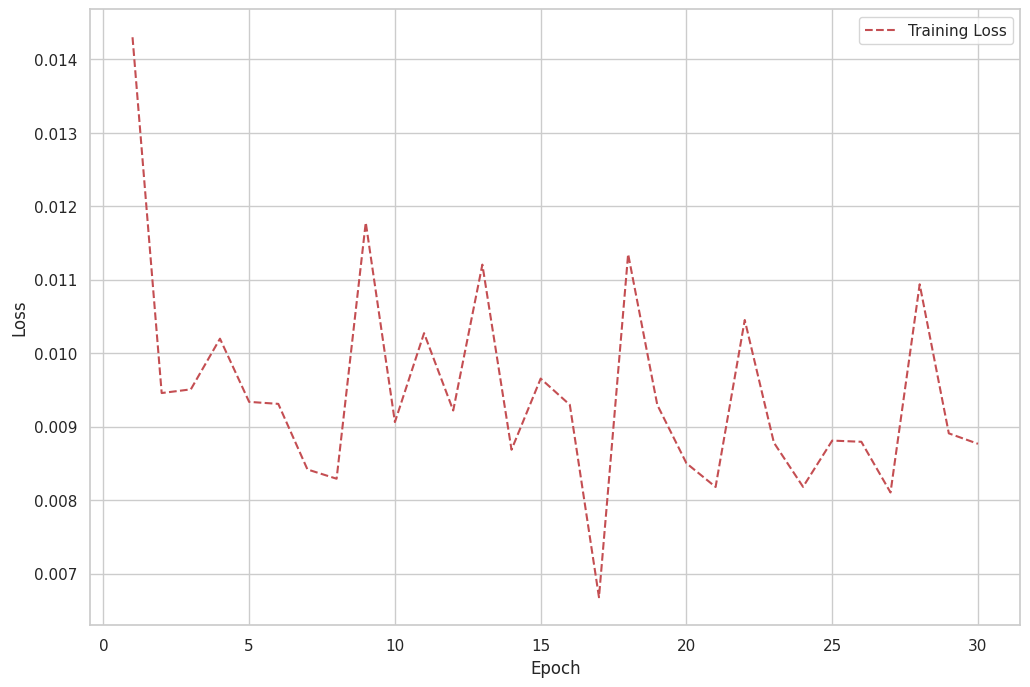

In [95]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 484ms/step


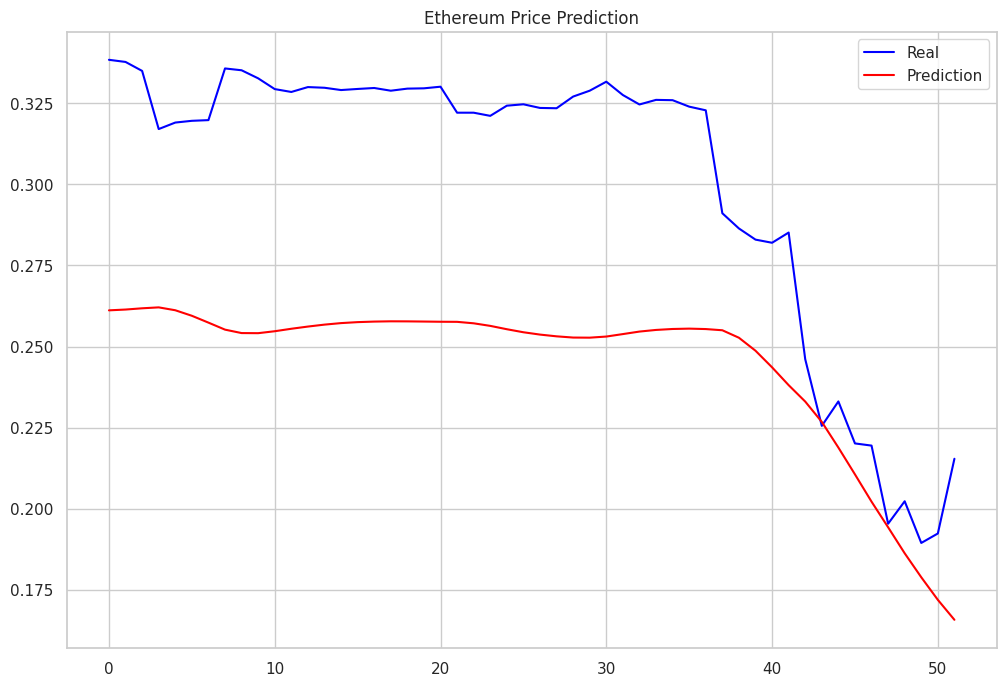

In [96]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Ethereum Price Prediction')
plt.legend()
plt.show()

#Bitcoin Cash (BCH)

In [97]:

df4 = data_top_6_currencies[data_top_6_currencies['symbol']=='BCH']

df4.shape

(495, 17)

In [98]:
print(df4)

              slug symbol          name        date  ranknow    open    high  \
6775  bitcoin-cash    BCH  Bitcoin Cash  2017-07-23        5  555.89  578.97   
6776  bitcoin-cash    BCH  Bitcoin Cash  2017-07-24        5  412.58  578.89   
6777  bitcoin-cash    BCH  Bitcoin Cash  2017-07-25        5  441.35  541.66   
6778  bitcoin-cash    BCH  Bitcoin Cash  2017-07-26        5  407.08  486.16   
6779  bitcoin-cash    BCH  Bitcoin Cash  2017-07-27        5  417.10  460.97   
...            ...    ...           ...         ...      ...     ...     ...   
7265  bitcoin-cash    BCH  Bitcoin Cash  2018-11-25        5  181.13  189.25   
7266  bitcoin-cash    BCH  Bitcoin Cash  2018-11-26        5  184.83  215.77   
7267  bitcoin-cash    BCH  Bitcoin Cash  2018-11-27        5  182.00  192.99   
7268  bitcoin-cash    BCH  Bitcoin Cash  2018-11-28        5  179.14  198.55   
7269  bitcoin-cash    BCH  Bitcoin Cash  2018-11-29        5  190.10  191.15   

         low   close       volume      

In [99]:
df4.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,row_id,market_billion,volume_million,volume_billion
6775,bitcoin-cash,BCH,Bitcoin Cash,2017-07-23,5,555.89,578.97,411.78,413.06,85013.0,0.0,0.0077,167.19,6776,0.0,0.000085,85013.0
6776,bitcoin-cash,BCH,Bitcoin Cash,2017-07-24,5,412.58,578.89,409.21,440.70,190952.0,0.0,0.1856,169.68,6777,0.0,0.000191,190952.0
6777,bitcoin-cash,BCH,Bitcoin Cash,2017-07-25,5,441.35,541.66,338.09,406.90,524908.0,0.0,0.3380,203.57,6778,0.0,0.000525,524908.0
6778,bitcoin-cash,BCH,Bitcoin Cash,2017-07-26,5,407.08,486.16,321.79,365.82,1784640.0,0.0,0.2679,164.37,6779,0.0,0.001785,1784640.0
6779,bitcoin-cash,BCH,Bitcoin Cash,2017-07-27,5,417.10,460.97,367.78,385.48,533207.0,0.0,0.1899,93.19,6780,0.0,0.000533,533207.0


In [100]:
d4 = df4.iloc[:, 5:10]
print(d4.head())
print(d4.shape)

        open    high     low   close     volume
6775  555.89  578.97  411.78  413.06    85013.0
6776  412.58  578.89  409.21  440.70   190952.0
6777  441.35  541.66  338.09  406.90   524908.0
6778  407.08  486.16  321.79  365.82  1784640.0
6779  417.10  460.97  367.78  385.48   533207.0
(495, 5)


Text(0.5, 1.0, 'Price of Bitcoin Cash')

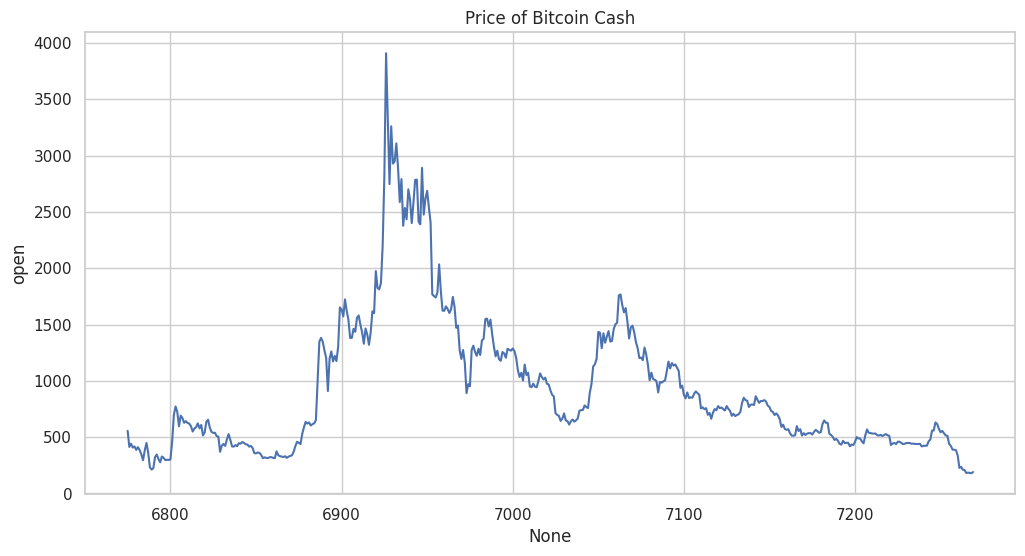

In [101]:
plt.figure(figsize=(12,6))
sns.lineplot(x=d4.index, y="open", data=d4).set_title("Price of Bitcoin Cash")

In [102]:
data = d4.iloc[:, 0]

print(data)

6775    555.89
6776    412.58
6777    441.35
6778    407.08
6779    417.10
         ...  
7265    181.13
7266    184.83
7267    182.00
7268    179.14
7269    190.10
Name: open, Length: 495, dtype: float64


In [103]:
hist = []
target = []
length = 90
for i in range(6775,len(data)-length):
    x = data[6775:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [104]:
hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1,1)

In [105]:
hist = hist.reshape(1,-1)

In [106]:
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(1952, 90, 1)


In [107]:
X_train = hist_scaled[:1900,:,:]
X_test = hist_scaled[1900:,:,:]
y_train = target_scaled[:1900,:]
y_test = target_scaled[1900:,:]

In [108]:
import tensorflow as tf
from tensorflow.keras import layers

In [109]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(90,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 90, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 90, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,025 (82.13 KB)

 Trainable params: 21,025 (82.13 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [111]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 0.0234
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0096
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0123
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 0.0104
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 0.0085
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0106
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0064
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0084
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0078
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0103
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 0.0104
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 0.0091
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0064
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0093
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step


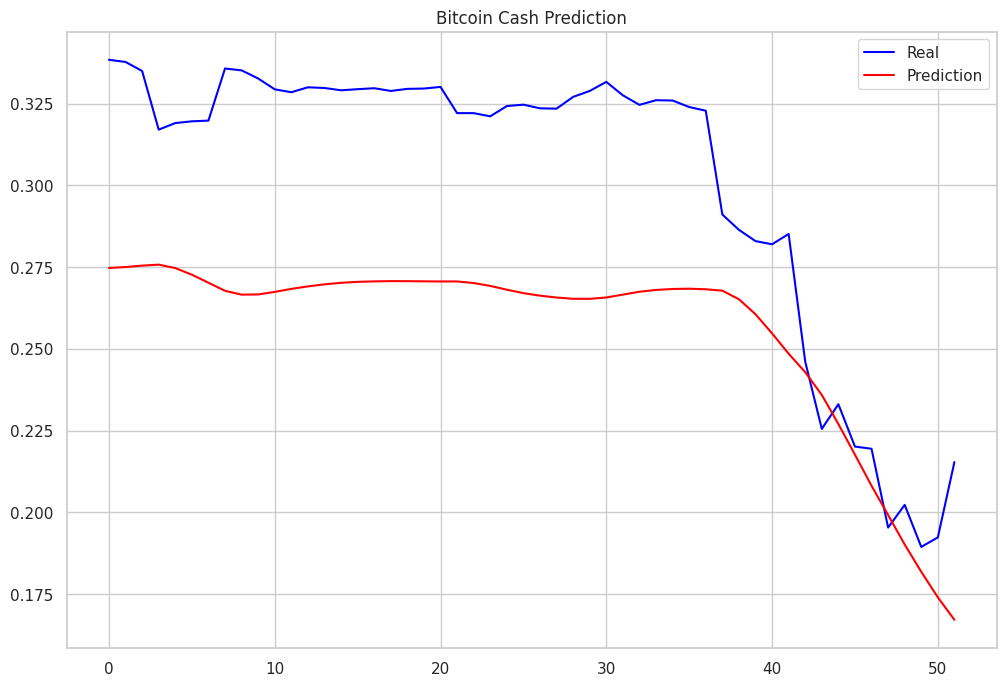

In [112]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Bitcoin Cash Prediction')
plt.legend()
plt.show()

#EOS

In [113]:
df5 = data_top_6_currencies[data_top_6_currencies['symbol']=='EOS']

df5.shape

(517, 17)

In [114]:
print(df5)

     slug symbol name        date  ranknow      open  high       low  close  \
7270  eos    EOS  EOS  2017-07-01        6  1.030000  1.07  0.989566   1.01   
7271  eos    EOS  EOS  2017-07-02        6  0.996521  2.88  0.822648   2.71   
7272  eos    EOS  EOS  2017-07-03        6  2.720000  5.40  2.630000   4.09   
7273  eos    EOS  EOS  2017-07-04        6  4.100000  4.19  2.930000   3.37   
7274  eos    EOS  EOS  2017-07-05        6  3.360000  3.52  2.730000   3.00   
...   ...    ...  ...         ...      ...       ...   ...       ...    ...   
7782  eos    EOS  EOS  2018-11-25        6  3.270000  3.43  3.030000   3.35   
7783  eos    EOS  EOS  2018-11-26        6  3.350000  3.41  3.080000   3.18   
7784  eos    EOS  EOS  2018-11-27        6  3.180000  3.18  2.900000   3.03   
7785  eos    EOS  EOS  2018-11-28        6  3.030000  3.37  3.030000   3.28   
7786  eos    EOS  EOS  2018-11-29        6  3.290000  3.30  2.930000   3.02   

            volume        market  close_ratio  spre

In [115]:
df5.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,row_id,market_billion,volume_million,volume_billion
7270,eos,EOS,EOS,2017-07-01,6,1.030000,1.07,0.989566,1.01,13613000.0,0.0,0.2540,0.08,7271,0.000000,0.013613,13613000.0
7271,eos,EOS,EOS,2017-07-02,6,0.996521,2.88,0.822648,2.71,320452000.0,0.0,0.9174,2.06,7272,0.000000,0.320452,320452000.0
7272,eos,EOS,EOS,2017-07-03,6,2.720000,5.40,2.630000,4.09,414950016.0,654930711.0,0.5271,2.77,7273,0.654931,0.414950,414950016.0
7273,eos,EOS,EOS,2017-07-04,6,4.100000,4.19,2.930000,3.37,218559008.0,550155157.0,0.3492,1.26,7274,0.550155,0.218559,218559008.0
7274,eos,EOS,EOS,2017-07-05,6,3.360000,3.52,2.730000,3.00,124339000.0,500626422.0,0.3418,0.79,7275,0.500626,0.124339,124339000.0


In [116]:
d5 = df5.iloc[:, 5:10]
print(d5.head())
print(d5.shape)

          open  high       low  close       volume
7270  1.030000  1.07  0.989566   1.01   13613000.0
7271  0.996521  2.88  0.822648   2.71  320452000.0
7272  2.720000  5.40  2.630000   4.09  414950016.0
7273  4.100000  4.19  2.930000   3.37  218559008.0
7274  3.360000  3.52  2.730000   3.00  124339000.0
(517, 5)


Text(0.5, 1.0, 'Price of EOS')

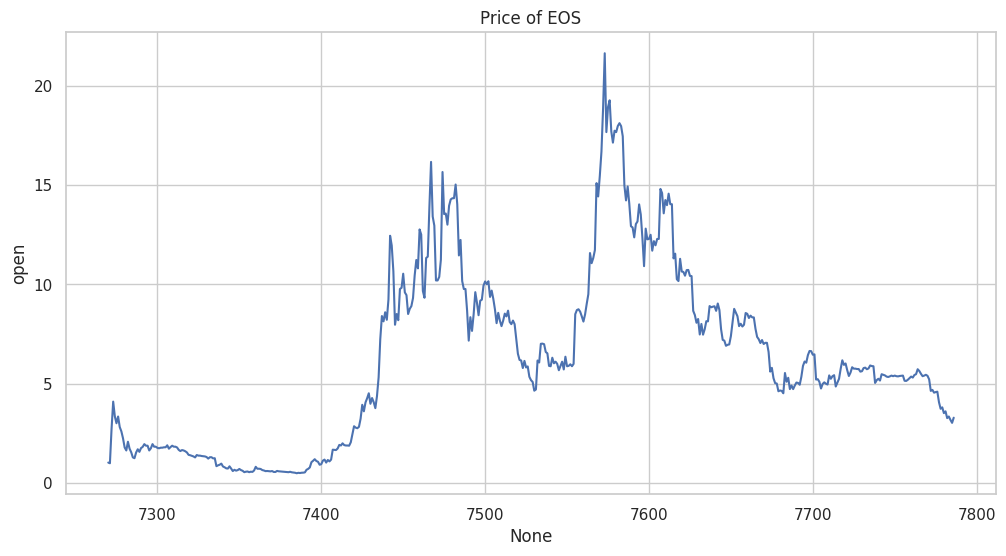

In [117]:
plt.figure(figsize=(12,6))
sns.lineplot(x=d5.index, y="open", data=d5).set_title("Price of EOS")

In [118]:
data = d5.iloc[:, 0]

print(data)

7270    1.030000
7271    0.996521
7272    2.720000
7273    4.100000
7274    3.360000
          ...   
7782    3.270000
7783    3.350000
7784    3.180000
7785    3.030000
7786    3.290000
Name: open, Length: 517, dtype: float64


In [119]:
hist = []
target = []
length = 90
for i in range(7270,len(data)-length):
    x = data[7270:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [120]:
hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1,1)

In [121]:
hist = hist.reshape(1,-1)

In [122]:
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(1952, 90, 1)


In [123]:
X_train = hist_scaled[:1900,:,:]
X_test = hist_scaled[1900:,:,:]
y_train = target_scaled[:1900,:]
y_test = target_scaled[1900:,:]

In [124]:
import tensorflow as tf
from tensorflow.keras import layers

In [125]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(90,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 90, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 90, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,025 (82.13 KB)

 Trainable params: 21,025 (82.13 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [127]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.0202
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.0084
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0120
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0131
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0119
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0111
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.0115
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0105
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0086
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0104
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 0.0100
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 0.0117
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0082
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.0114
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/ste

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


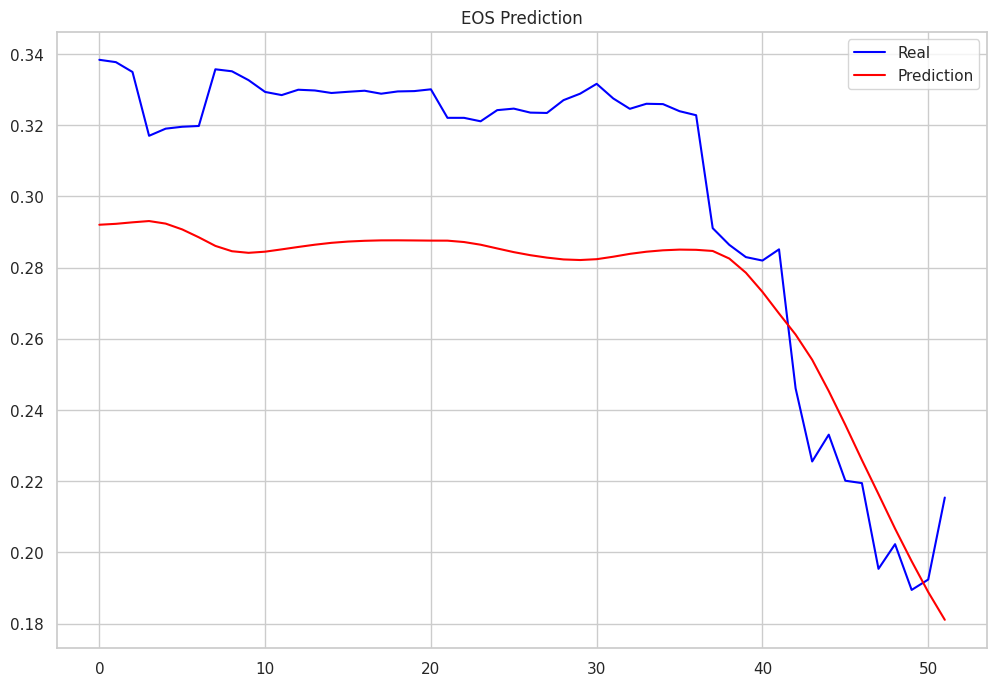

In [128]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('EOS Prediction')
plt.legend()
plt.show()

#Stellar

In [129]:
df6 = data_top_6_currencies[data_top_6_currencies['name']=='Stellar']

df6.shape

(1578, 17)

In [130]:
print(df6)

         slug symbol     name        date  ranknow      open      high  \
5197  stellar    XLM  Stellar  2014-08-05        4  0.002976  0.003387   
5198  stellar    XLM  Stellar  2014-08-06        4  0.002373  0.003402   
5199  stellar    XLM  Stellar  2014-08-07        4  0.002686  0.003042   
5200  stellar    XLM  Stellar  2014-08-08        4  0.002493  0.003243   
5201  stellar    XLM  Stellar  2014-08-09        4  0.002884  0.003710   
...       ...    ...      ...         ...      ...       ...       ...   
6770  stellar    XLM  Stellar  2018-11-25        4  0.155430  0.159619   
6771  stellar    XLM  Stellar  2018-11-26        4  0.159195  0.163263   
6772  stellar    XLM  Stellar  2018-11-27        4  0.144355  0.146664   
6773  stellar    XLM  Stellar  2018-11-28        4  0.144111  0.167606   
6774  stellar    XLM  Stellar  2018-11-29        4  0.161831  0.172107   

           low     close       volume        market  close_ratio  spread  \
5197  0.002349  0.002440      30316

In [131]:
df6.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,row_id,market_billion,volume_million,volume_billion
5197,stellar,XLM,Stellar,2014-08-05,4,0.002976,0.003387,0.002349,0.002440,30316.0,767679.0,0.0877,0.0,5198,0.000768,0.000030,30316.0
5198,stellar,XLM,Stellar,2014-08-06,4,0.002373,0.003402,0.002266,0.002657,35820.0,966370.0,0.3442,0.0,5199,0.000966,0.000036,35820.0
5199,stellar,XLM,Stellar,2014-08-07,4,0.002686,0.003042,0.002455,0.002501,142864.0,1079148.0,0.0784,0.0,5200,0.001079,0.000143,142864.0
5200,stellar,XLM,Stellar,2014-08-08,4,0.002493,0.003243,0.002493,0.002881,93708.0,1260109.0,0.5173,0.0,5201,0.001260,0.000094,93708.0
5201,stellar,XLM,Stellar,2014-08-09,4,0.002884,0.003710,0.002873,0.003481,233579.0,1645185.0,0.7264,0.0,5202,0.001645,0.000234,233579.0


In [132]:
d = df6.iloc[:, 5:10]
print(d.head())
print(d.shape)

          open      high       low     close    volume
5197  0.002976  0.003387  0.002349  0.002440   30316.0
5198  0.002373  0.003402  0.002266  0.002657   35820.0
5199  0.002686  0.003042  0.002455  0.002501  142864.0
5200  0.002493  0.003243  0.002493  0.002881   93708.0
5201  0.002884  0.003710  0.002873  0.003481  233579.0
(1578, 5)


Text(0.5, 1.0, 'Price of Stellar')

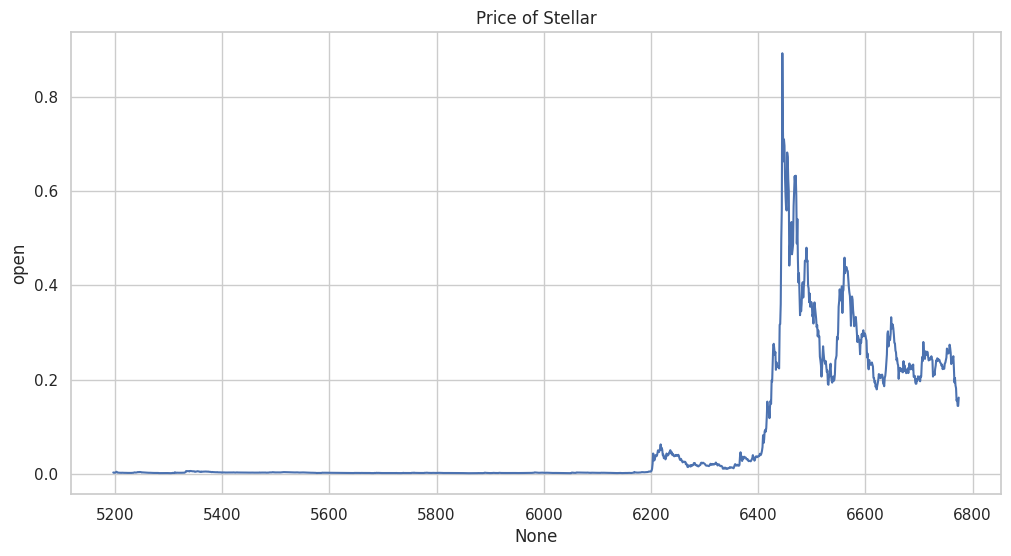

In [133]:
plt.figure(figsize=(12,6))
sns.lineplot(x=d.index, y="open", data=d).set_title("Price of Stellar")

In [134]:
print(d)

          open      high       low     close       volume
5197  0.002976  0.003387  0.002349  0.002440      30316.0
5198  0.002373  0.003402  0.002266  0.002657      35820.0
5199  0.002686  0.003042  0.002455  0.002501     142864.0
5200  0.002493  0.003243  0.002493  0.002881      93708.0
5201  0.002884  0.003710  0.002873  0.003481     233579.0
...        ...       ...       ...       ...          ...
6770  0.155430  0.159619  0.133734  0.159607  137467000.0
6771  0.159195  0.163263  0.137487  0.144795  105913000.0
6772  0.144355  0.146664  0.137987  0.144374   81742500.0
6773  0.144111  0.167606  0.144111  0.162237  101285000.0
6774  0.161831  0.172107  0.155423  0.165080   88862064.0

[1578 rows x 5 columns]


In [135]:
data = d.iloc[:, 0]
print(len(data))
print(data)
hist = []
target = []
length = 90
for i in range(5197, len(data)-length):
    x = data[5197,:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

1578
5197    0.002976
5198    0.002373
5199    0.002686
5200    0.002493
5201    0.002884
          ...   
6770    0.155430
6771    0.159195
6772    0.144355
6773    0.144111
6774    0.161831
Name: open, Length: 1578, dtype: float64


In [136]:
hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1,1)
hist=hist.reshape(-1,1)

In [139]:
data = d.iloc[:, 0]
print(len(data))
print(data)
hist = []
target = []
length = 90

# Adjust the loop range to ensure it executes
for i in range(len(data) - length - 1):  # Iterate through the entire data
    x = data.iloc[i : i + length].values  # Extract data slice using iloc and convert to numpy array
    y = data.iloc[i + length]      # Extract target value using iloc
    hist.append(x)
    target.append(y)

hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1, 1)
hist = hist.reshape(-1, 1)

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
hist

1578
5197    0.002976
5198    0.002373
5199    0.002686
5200    0.002493
5201    0.002884
          ...   
6770    0.155430
6771    0.159195
6772    0.144355
6773    0.144111
6774    0.161831
Name: open, Length: 1578, dtype: float64


array([[0.002976],
       [0.002373],
       [0.002686],
       ...,
       [0.15543 ],
       [0.159195],
       [0.144355]])

In [140]:
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(1952, 90, 1)


In [141]:
X_train = hist_scaled[:1900,:,:]
X_test = hist_scaled[1900:,:,:]
y_train = target_scaled[:1900,:]
y_test = target_scaled[1900:,:]

In [142]:
import tensorflow as tf
from tensorflow.keras import layers

In [143]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(90,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 90, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 90, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,025 (82.13 KB)

 Trainable params: 21,025 (82.13 KB)

 Non-trainable params: 0 (0.00 B)

In [144]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [145]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.0117
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0119
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0086
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - loss: 0.0101
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 0.0110
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0076
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - loss: 0.0082
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0088
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 0.0082
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0097
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0071
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0088
Epoch 13/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.0093
Epoch 14/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.0105
Epoch 15/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/ste

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


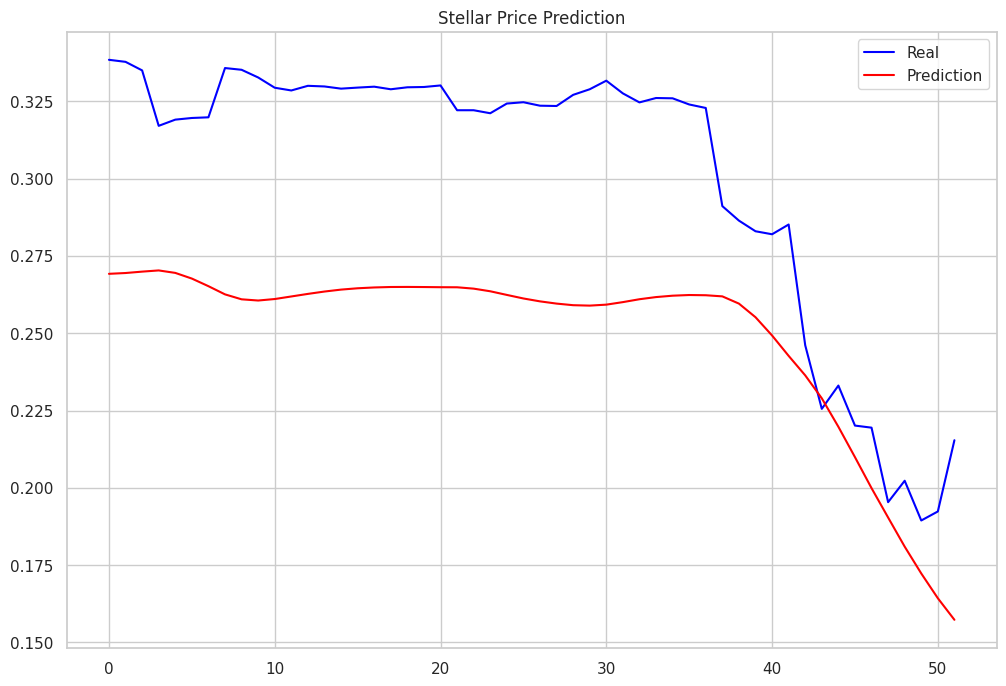

In [146]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Stellar Price Prediction')
plt.legend()
plt.show()